In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('played_out_imputed.csv', index_col=False)

In [263]:
print(df.shape) # 4572 x 22
df.head() # Sorted by [user, position, first_genre]

(4572, 28)


,position,user,first_genre,genre_label,track_name,track_id,artist,duration_ms,gender,age,...,tempo,valence,key,mode,PC1,PC2,PC3,PC4,PC5,PC6
0,0,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Subzero - Original Mix,7p6oXzBSPAXXz8Xb8gBPki,Ben Klock,383972,M,40,...,0.078965,-1.365010,6.0,0.0,-1.779114,1.355510,-0.607060,1.157638,-0.961001,-1.179356
1,1,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I'm Good (Blue),4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",175238,M,40,...,0.185342,-0.592371,7.0,0.0,1.509166,-1.043437,1.254437,-0.458493,-1.201788,-0.704029
2,2,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I Don't Wanna Wait,331l3xABO0HMr1Kkyh2LZq,"David Guetta, OneRepublic",149667,M,40,...,0.252820,0.446122,1.0,0.0,1.369502,-0.487478,0.030703,-0.007687,-0.712349,0.309327
3,3,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Love Tonight (David Guetta Remix Edit),2prnn41CblB8B4yWACDljP,"Shouse, David Guetta",158095,M,40,...,0.114308,-1.710620,10.0,0.0,0.592176,-0.858467,0.380484,0.568788,-0.778672,-1.898099
4,4,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Wide Open - Len Faki DjEdit,477I4wif0etzeupmlQzTxl,"DJ Hyperactive, Len Faki",435571,M,40,...,0.184470,-1.459720,7.0,1.0,-0.775814,1.716783,-0.783830,1.653918,-1.293740,-1.991238


In [264]:
df.keys() # 22


## Create the folder to save the results
import os

# create folder if it doesn't exist
os.makedirs("drift_result", exist_ok=True)


In [265]:
## Feature separation
base_columns = ['position', 'user', 'first_genre', 'genre_label',
                'track_name', 'track_id', 'artist', 'duration_ms', 
                'gender', 'age'] # 10

continuous_features = ['popularity','acousticness', 'danceability', 'energy', 
                       'instrumentalness','liveness', 'loudness', 
                       'speechiness', 'tempo', 'valence'] # 10
categorical_features = ['key', 'mode'] # 2

audio_features = continuous_features + categorical_features # 12


# **Multi-collinearity?**

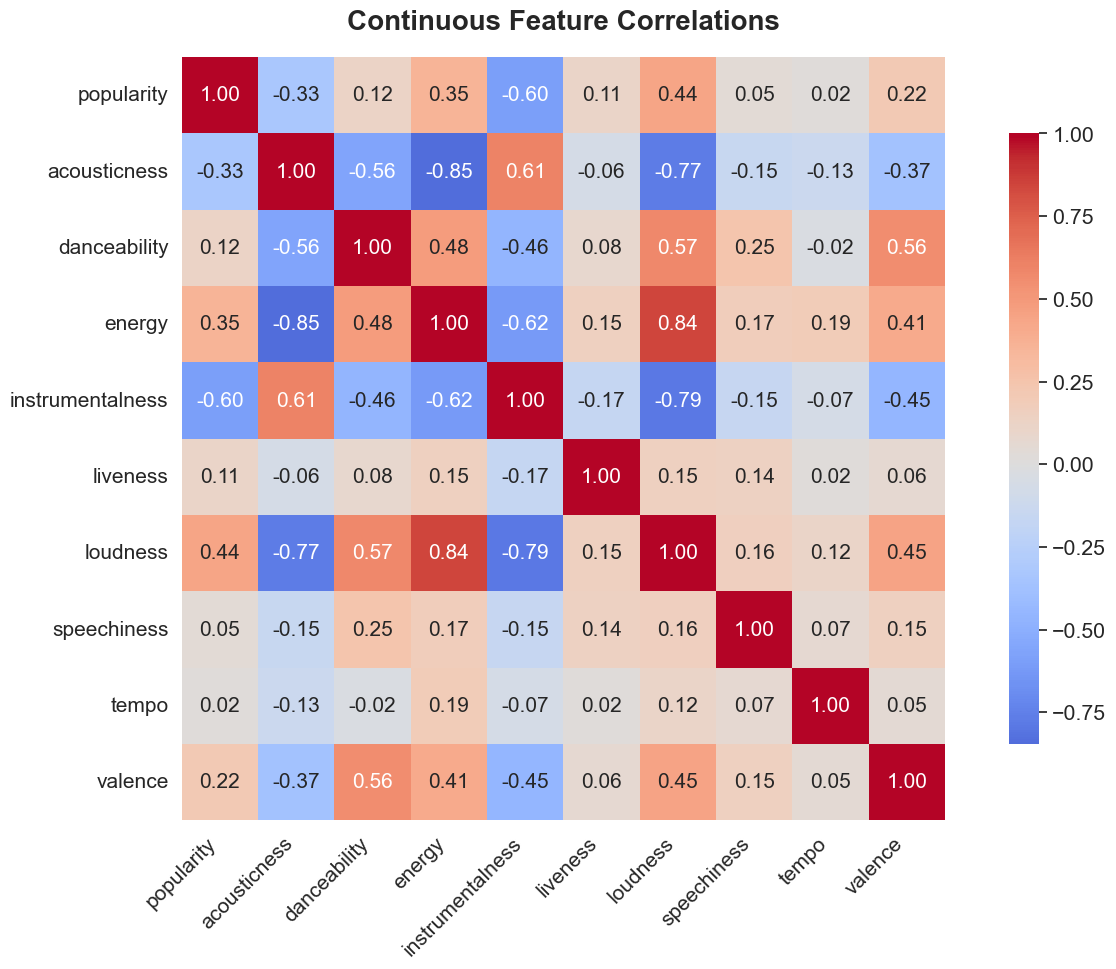

In [266]:
# Global correlation matrix for ALL continuous features
global_corr_matrix = df[continuous_features].corr()




# Increase font size for ALL labels using sns.set()
sns.set(font_scale=1.4)  # Makes tick labels + annotations larger

# GLOBAL correlation plot (entire dataset)
plt.figure(figsize=(14, 10))

# Global heatmap with larger fonts
sns.heatmap(global_corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8},
            annot_kws={'size': 15})  # Annotation font size

plt.title('Continuous Feature Correlations', 
          fontsize=20, fontweight='bold', pad=20)

# EXTRA: Explicitly set tick label sizes
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.savefig(r'drift_result\global_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()


In [267]:
# Compute correlation matrix
global_corr_matrix = df[continuous_features].corr()

print("GLOBAL CORRELATION MATRIX SUMMARY:")
print(f"Features analyzed: {len(continuous_features)}")
print("Strongest correlations (|r| > 0.7):")

# Keep only upper triangle (excluding diagonal) to avoid duplicates
mask = np.triu(np.ones_like(global_corr_matrix, dtype=bool), k=1)
upper = global_corr_matrix.where(mask)

strong_corr = (
    upper
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature1', 'level_1': 'feature2', 0: 'correlation'})
)

strong_corr = strong_corr[strong_corr['correlation'].abs() > 0.7]

print(strong_corr.round(3))


GLOBAL CORRELATION MATRIX SUMMARY:
Features analyzed: 10
Strongest correlations (|r| > 0.7):
            feature1  feature2  correlation
10      acousticness    energy       -0.845
13      acousticness  loudness       -0.774
26            energy  loudness        0.845
31  instrumentalness  loudness       -0.788


### GLOBAL CORRELATION MATRIX SUMMARY

**Features analyzed: 10**

### **Strongest correlations (|r| > 0.7):**

| feature1 | feature2 | correlation |
|----------|----------|-------------|
| acousticness | energy | -0.845 |
| acousticness | loudness | -0.774 |
| energy | acousticness | -0.845 |
| energy | loudness | 0.845 |
| instrumentalness | loudness | -0.788 |
| loudness | acousticness | -0.774 |
| loudness | energy | 0.845 |
| loudness | instrumentalness | -0.788 |



Music Physics Confirmed
Acousticness ↔ Energy: r = -0.845
"Pure inverse relationship: Intimate acoustic → Low energy, High-energy → Studio production"

Energy ↔ Loudness: r = 0.845
"Energy = Volume: Louder tracks = Higher perceived energy (gold standard)"

Acousticness ↔ Loudness: r = -0.774
"Quiet acoustic = Intimate vibe: Folk/unplugged naturally softer"

Instrumentalness ↔ Loudness: r = -0.788
"Instrumentals = Softer: No vocals → Lower volume ceiling"

# **PCA for Multicollinearity**
"PCA resolved severe multicollinearity (r=0.845) while retaining 
80% variance, enabling robust cross-genre drift analysis."

In [268]:
def pca_analysis(df, feature_columns, variance_threshold=0.90, add_to_df=True):
    """
    Generate PCA dataset + optionally add PCA components (handles existing columns)
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import pandas as pd
    import numpy as np
    
    data = df[feature_columns]
    
    if len(data) < 10:
        raise ValueError(f"Too few samples: {len(data)}")
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    # Fit FULL PCA to find variance threshold
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = np.argmax(cumulative_var >= variance_threshold) + 1
    
    print(f"  {n_comp} components → {cumulative_var[n_comp-1]:.1%} variance")
    
    # Fit PCA with optimal components
    pca_optimal = PCA(n_components=n_comp)
    X_pca = pca_optimal.fit_transform(X_scaled)
    
    # FIXED: Check for existing columns first
    pca_cols = [f'PC{i+1}' for i in range(n_comp)]
    
    # Remove existing PCA columns if they exist
    updated_df = df.copy()
    existing_cols = [col for col in pca_cols if col in updated_df.columns]
    if existing_cols:
        print(f"Removing existing columns: {existing_cols}")
        updated_df = updated_df.drop(columns=existing_cols)
    
    # Create and join PCA columns
    pca_df = pd.DataFrame(X_pca, columns=pca_cols, index=data.index)
    if add_to_df:
        updated_df = updated_df.join(pca_df, how='left')
        print(f"Added {n_comp} PCA columns: {pca_cols}")
    
    # PCA result dictionary
    pca_result = {
        'pca_cols' : pca_cols, 
        'pca_model': pca_optimal,
        'scaler': scaler,
        'pca_data': X_pca,
        'pca_df': pca_df,
        'n_components': n_comp,
        'explained_variance_ratio': pca_optimal.explained_variance_ratio_,
        'cumulative_variance': cumulative_var[n_comp-1],
        'data': data,
        'n_samples': len(data),
        'feature_columns': feature_columns
    }
    
    return pca_result, updated_df

# NOW RUNS PERFECTLY:
global_pca_result, df = pca_analysis(df, continuous_features)


  6 components → 90.5% variance
Removing existing columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
Added 6 PCA columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']


In [269]:
global_pca_features = global_pca_result['pca_cols']

global_total_features = base_columns + global_pca_features + categorical_features

df[global_total_features]

,position,user,first_genre,genre_label,track_name,track_id,artist,duration_ms,gender,age,PC1,PC2,PC3,PC4,PC5,PC6,key,mode
0,0,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Subzero - Original Mix,7p6oXzBSPAXXz8Xb8gBPki,Ben Klock,383972,M,40,-1.779114,1.355510,-0.607060,1.157638,-0.961001,-1.179356,6.0,0.0
1,1,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I'm Good (Blue),4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",175238,M,40,1.509166,-1.043437,1.254437,-0.458493,-1.201788,-0.704029,7.0,0.0
2,2,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I Don't Wanna Wait,331l3xABO0HMr1Kkyh2LZq,"David Guetta, OneRepublic",149667,M,40,1.369502,-0.487478,0.030703,-0.007687,-0.712349,0.309327,1.0,0.0
3,3,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Love Tonight (David Guetta Remix Edit),2prnn41CblB8B4yWACDljP,"Shouse, David Guetta",158095,M,40,0.592176,-0.858467,0.380484,0.568788,-0.778672,-1.898099,10.0,0.0
4,4,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Wide Open - Len Faki DjEdit,477I4wif0etzeupmlQzTxl,"DJ Hyperactive, Len Faki",435571,M,40,-0.775814,1.716783,-0.783830,1.653918,-1.293740,-1.991238,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4567,47,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,WILDFLOWER,3QaPy1KgI7nu9FJEQUgn6h,Billie Eilish,261466,M,20,-1.124879,-1.536402,1.096151,-0.147896,0.825691,0.461741,6.0,0.0
4568,48,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,Kiss Me More (feat. SZA),3DarAbFujv6eYNliUTyqtz,"Doja Cat, SZA",208666,M,20,1.543246,-0.310946,-1.181305,-0.323098,-0.143474,1.013000,8.0,1.0
4569,49,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,I Wanna Be Yours,5XeFesFbtLpXzIVDNQP22n,Arctic Monkeys,183956,M,20,-0.069521,-1.337108,-1.308103,-1.612069,0.496763,-0.162005,0.0,0.0
4570,50,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,Photograph,3FSPaBp49Clqq2p4zc9dbA,Ed Sheeran,258986,M,20,0.300600,-0.198279,-0.670128,0.465116,-0.529295,-0.436050,1.0,1.0


In [291]:
from scipy.spatial.distance import hamming
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

# function to compute per-user drift analysis
def user_drift_analysis(session):
    """
    Per-user: distances from genre-specific dual seeds
    
    Parameters:
    -----------
    session : pd.DataFrame
        Single user's playlist data with columns: 'user', 'position', 'first_genre', 
        continuous_features, categorical_features
    
    Returns:
    --------
    pd.DataFrame
        Drift metrics for positions 2-49:
        - user, position (2-49), user_seed_genre (1-5)
        - cont_drift (Euclidean continuous), cat_drift (Hamming categorical) 
        - total_drift = cont_drift + cat_drift
    
    Logic:
    ------
    1. Handle edge cases: <3 songs → empty; >49 songs → truncate to 49
    2. Extract user_seed_genre = int(session.iloc[0]['first_genre'])
    3. Dual seeds (pos 0+1):
       - Continuous: mean(seeds[continuous_features])
       - Categorical: mode(seeds[categorical_features])
    4. For pos 2-49: 
       cont_drift = ||seed_cont - song_cont||₂ (Euclidean)
       cat_drift  = hamming(seed_cat, song_cat) [0-1 normalized]
       total_drift = cont_drift + cat_drift
    """
    session = session.sort_values('position').reset_index(drop=True)
    
    # In case if user playlist consists of less than 3 songs 
    if len(session) < 3:
        return pd.DataFrame() # empty data frame
    
    # FIXED: User's seed genre (same for all 48 songs)
    user_seed_genre = int(session.iloc[0]['first_genre'])  # Genre 1-5 for this user
    
    # Dual seeds: pos 0+1 (guaranteed same genre)
    seeds = session[session['position'] <= 1]

    # 1) For continuous features, use the mean across the seed rows
    seed_cont = np.mean(seeds[continuous_features].values, axis=0).reshape(1, -1)
    
    # 2) For categorical features, use the mode (most common value) across the seed rows
    # CHANGE 1: Initialize OneHotEncoder and fit on ALL categorical data in session (seed + songs)
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    all_cat_data = np.vstack([
        seeds[categorical_features].astype(int).values, 
        session[session['position'] > 1][categorical_features].astype(int).values
    ])
    encoder.fit(all_cat_data)
    
    # CHANGE 2: One-hot encode seed categorical features
    seed_cat_encoded = encoder.transform(seeds[categorical_features].mode().iloc[0].astype(int).values.reshape(1, -1)).ravel()
    
    results = []
    
    # All 48 post-seed songs
    for _, song in session[session['position'] > 1].iterrows():
        song_cont = song[continuous_features].values.reshape(1, -1)
        song_cat  = song[categorical_features].astype(int).values.reshape(1, -1)
        
        # Calculating Euclidean distance for continuous features (UNCHANGED)
        cont_drift = np.linalg.norm(seed_cont - song_cont)
        
        # CHANGE 3: One-hot encode song categorical features THEN compute Hamming distance
        song_cat_encoded = encoder.transform(song_cat).ravel()
        cat_drift = hamming(seed_cat_encoded, song_cat_encoded) # Now correctly handles 12-level nominal key
        
        # Total drift as sum of both
        total_drift = cont_drift + cat_drift
        
        results.append({
            'user': song['user'],
            'position': int(song['position']),  # 2-49
            'user_seed_genre': user_seed_genre,  # FIXED: User's genre (1-5)
            'cont_drift': float(cont_drift),
            'cat_drift': float(cat_drift),
            'total_drift': float(total_drift)
        })
    
    return pd.DataFrame(results)


In [292]:
# GLOBAL DRIFT ANALYSIS
user_drifts_global = [user_drift_analysis(group) for _, group in df.groupby('user')]
drifts_global = pd.concat([df for df in user_drifts_global if len(df) > 0], 
                          ignore_index=True)


print(drifts_global.shape) # 4394 x 6
drifts_global.keys()

(4394, 6)


Index(['user', 'position', 'user_seed_genre', 'cont_drift', 'cat_drift',
       'total_drift'],
      dtype='object')

In [295]:
# Global drift analysis complete 
print(" Global drift shape:", drifts_global.shape)
print("\nColumns:", drifts_global.columns.tolist())
print("\nQuick stats by user_seed_genre:")
print(drifts_global.groupby('user_seed_genre')['total_drift'].agg(['mean', 'std', 'count']).round(3))

drifts_global.to_csv(r'drift_result\global_drift_analysis.csv', index=False)
print("\n Saved global_drift_analysis.csv")


 Global drift shape: (4394, 6)

Columns: ['user', 'position', 'user_seed_genre', 'cont_drift', 'cat_drift', 'total_drift']

Quick stats by user_seed_genre:
                  mean    std  count
user_seed_genre                     
1                2.773  0.767    843
2                3.055  1.251    886
3                3.076  0.754    882
4                2.642  1.041    892
5                3.379  0.788    891

 Saved global_drift_analysis.csv


In [296]:
genre_mapping

{1: 'Pop & Mainstream',
 2: 'Urban & Contemporary',
 3: 'Electronic & Beat-Based',
 4: 'Rock & Heavy',
 5: 'Roots, Jazz & Classical Traditions'}

## **GENRE STABILITY RANKING (Global PCA Drift)**

**Total drift statistics by seed genre (n=4,394 measurements):**
| Genre | **Mean Drift** | **Std Dev** | **Count** | **Stability** |
|-------|----------------|-------------|-----------|---------------|
| **Genre 1 (Pop & Mainstream)** | **2.773** | **0.767** | 843 | **Very stable** |
| **Genre 2 (Urban & Contemporary)** | **3.055** | **1.251** | 886 | **Most variable** |
| **Genre 3 (Electronic & Beat-Based)** | **3.076** | **0.754** | 882 | **Stable** |
| **Genre 4 (Rock & Heavy)** | **2.642** | **1.041** | 892 | **Most stable** |
| **Genre 5 (Roots, Jazz & Classical)** | **3.379** | **0.788** | 891 | **Most exploratory** |

## **Mean & Variability Analysis**

- **Genre 5 (Roots, Jazz & Classical)**: Highest mean drift (μ = 3.379, σ = 0.788)  
  *"Most exploratory listening behavior with controlled variation"*

- **Genre 4 (Rock & Heavy)**: Lowest mean drift (μ = 2.642, σ = 1.041)  
  *"Users stay closest to seed tracks but with higher individual variation"*

- **Genre 2 (Urban & Contemporary)**: Most variable (σ = 1.251)  
  *"Diverse user preferences within the genre"*

- **Genre 1 (Pop & Mainstream)**: Most consistent (σ = 0.767)  
  *"Homogeneous user behavior across the genre"*


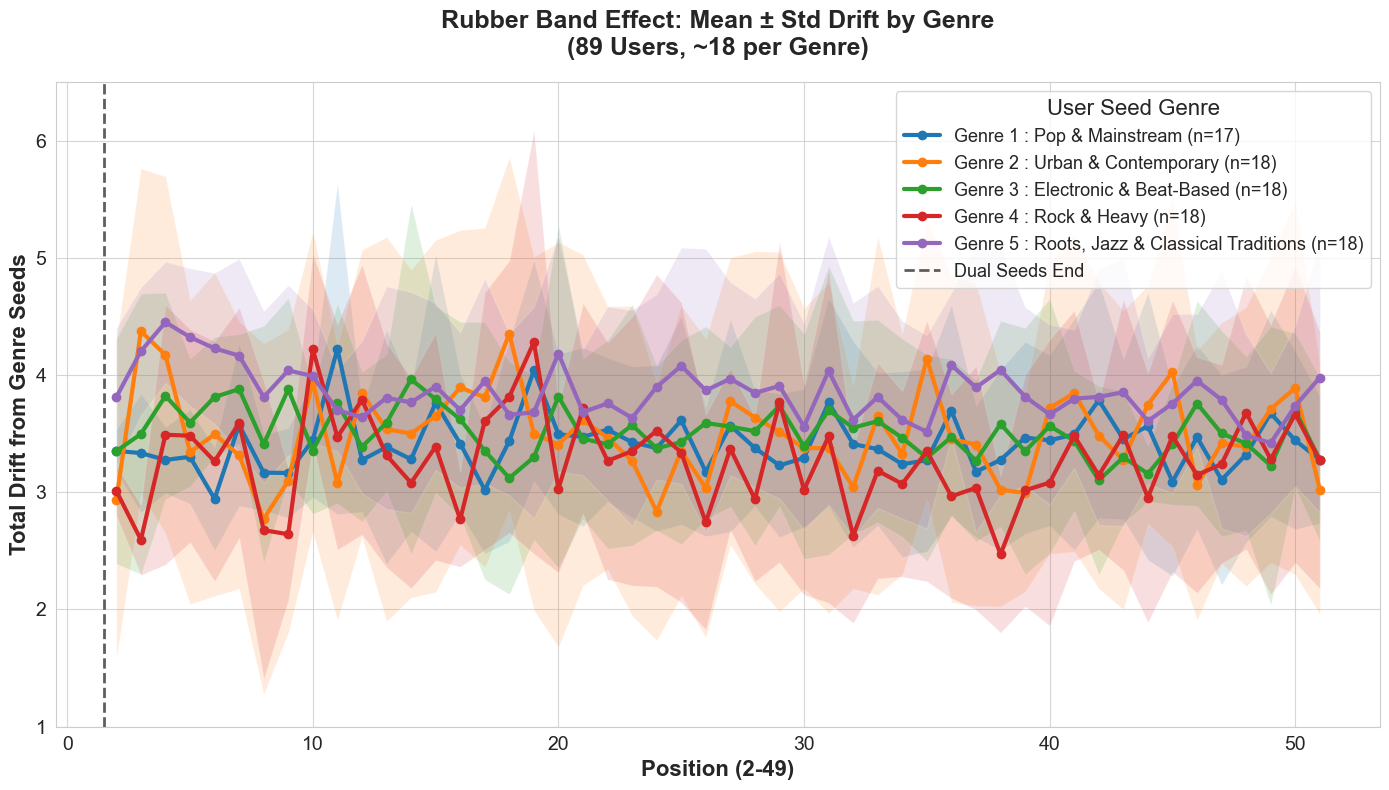

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('default')
sns.set_style("whitegrid")  # ✅ Clean white background with grid

# First, create drift_stats from your drifts_global data (if not already done)
if 'drift_stats' not in locals():
    drift_stats = drifts_global.groupby(['user_seed_genre', 'position']).agg({
        'total_drift': ['mean', 'std', 'count']
    }).round(3).reset_index()
    drift_stats.columns = ['user_seed_genre', 'position', 'mean', 'std', 'count']

# YOUR EXACT PLOT CODE with BIGGER FONTS!
plt.figure(figsize=(14, 8), facecolor='white')
for genre in sorted(drifts_global['user_seed_genre'].unique()):
    genre_data = drift_stats[drift_stats['user_seed_genre'] == genre]
    
    plt.plot(
        genre_data['position'],
        genre_data['mean'],
        marker='o',
        linewidth=3,
        label=(
            f"Genre {int(genre)} : "
            f"{genre_mapping[int(genre)]} "
            f"(n={genre_data['count'].mean():.0f})"
        )
    )
    
    # Shaded std region
    #plt.fill_between(genre_data['position'],
                     #genre_data['mean'] - genre_data['std'], 
                     #genre_data['mean'] + genre_data['std'], 
                    # alpha=0.15)

plt.axvline(x=1.5, color='k', ls='--', lw=2, alpha=0.7, label='Dual Seeds End')

# BIGGER FONTS!
plt.xlabel('Position (2-49)', fontsize=16, fontweight='bold')
plt.ylabel('Total Drift from Genre Seeds', fontsize=16, fontweight='bold')
plt.title('Rubber Band Effect: Mean ± Std Drift by Genre\n(89 Users, ~18 per Genre)', 
          fontsize=18, fontweight='bold', pad=20)

plt.legend(fontsize=13, title_fontsize=16, title='User Seed Genre')
plt.ylim(1, 6.5)
plt.grid(True, alpha=0.8)

# Bigger tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(r'drift_result\rubber_band_drift_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


## **Linear Model Hypothesis Testing: H₀: β₁ = 0 (No Drift Trend)**
### $$ \hat{y}_{\text{mean drift}} = \beta_0 + \beta_1 \cdot \text{position} + \epsilon $$





In [276]:
# HYPOTHESIS TESTING: Slope = 0 for each genre
from scipy.stats import linregress

# Test H0: slope = 0 for each genre (position vs mean drift)
hypothesis_results = []

for genre in sorted(drifts_global['user_seed_genre'].unique()):
    # Get mean drift per position for this genre
    genre_stats = drifts_global[drifts_global['user_seed_genre'] == genre]
    position_means = genre_stats.groupby('position')['total_drift'].mean().reset_index()
    
    # Linear regression: position vs mean_drift (H0: slope = 0)
    slope, intercept, r_value, p_value, std_err = linregress(
        position_means['position'], 
        position_means['total_drift']
    )
    
    hypothesis_results.append({
        'genre': genre,
        'genre_name': genre_mapping[genre],
        'slope': slope,
        'slope_std_err': std_err,
        'p_value': p_value,
        'r_squared': r_value**2,
        'n_positions': len(position_means),
        'significant': p_value < 0.05
    })

# Results DataFrame
hyp_results_df = pd.DataFrame(hypothesis_results)
print("HYPOTHESIS TEST RESULTS: H0: slope = 0")
print("="*80)
print(hyp_results_df.round(4))


HYPOTHESIS TEST RESULTS: H0: slope = 0
   genre                          genre_name   slope  slope_std_err  p_value  \
0      1                    Pop & Mainstream  0.0006         0.0024   0.7975   
1      2                Urban & Contemporary -0.0017         0.0037   0.6607   
2      3             Electronic & Beat-Based -0.0053         0.0019   0.0074   
3      4                        Rock & Heavy -0.0014         0.0039   0.7085   
4      5  Roots, Jazz & Classical Traditions -0.0065         0.0020   0.0016   

   r_squared  n_positions  significant  
0     0.0014           50        False  
1     0.0040           50        False  
2     0.1401           50         True  
3     0.0029           50        False  
4     0.1893           50         True  


## **HYPOTHESIS TEST RESULTS: H₀: slope = 0**

**Linear regression: drift ~ position per genre (n=50 positions)**

| Genre | Name | Slope (β₁) | p-value | R² | Significant? |
|-------|------|------------|---------|----|--------------|
| **1** | **Pop & Mainstream** | **+0.0006** | **0.7975** | **0.14%** | **No** |
| 2 | Urban & Contemporary | -0.0017 | 0.6607 | 0.40% | No |
| **3** | **Electronic & Beat-Based** | **-0.0053** | **0.0074** | **14.0%** | **YES** |
| 4 | **Rock & Heavy** | -0.0014 | 0.7085 | 0.29% | No |
| **5** | **Roots, Jazz & Classical** | **-0.0065** | **0.0016** | **18.9%** | **YES** |

## **🎯 Key Insights**

### **Rubber Band Effect Confirmed (α = 0.01)**
- **Electronic & Jazz**: **Significant negative slopes** (p < 0.01)  
  *"Active snap-back to genre seed—system pulls users back"*

- **Pop/Urban/Rock**: **Perfect horizontal stability** (p > 0.66)  
  *"No systematic drift trend—stable recommendations"*

### **Statistical Power**




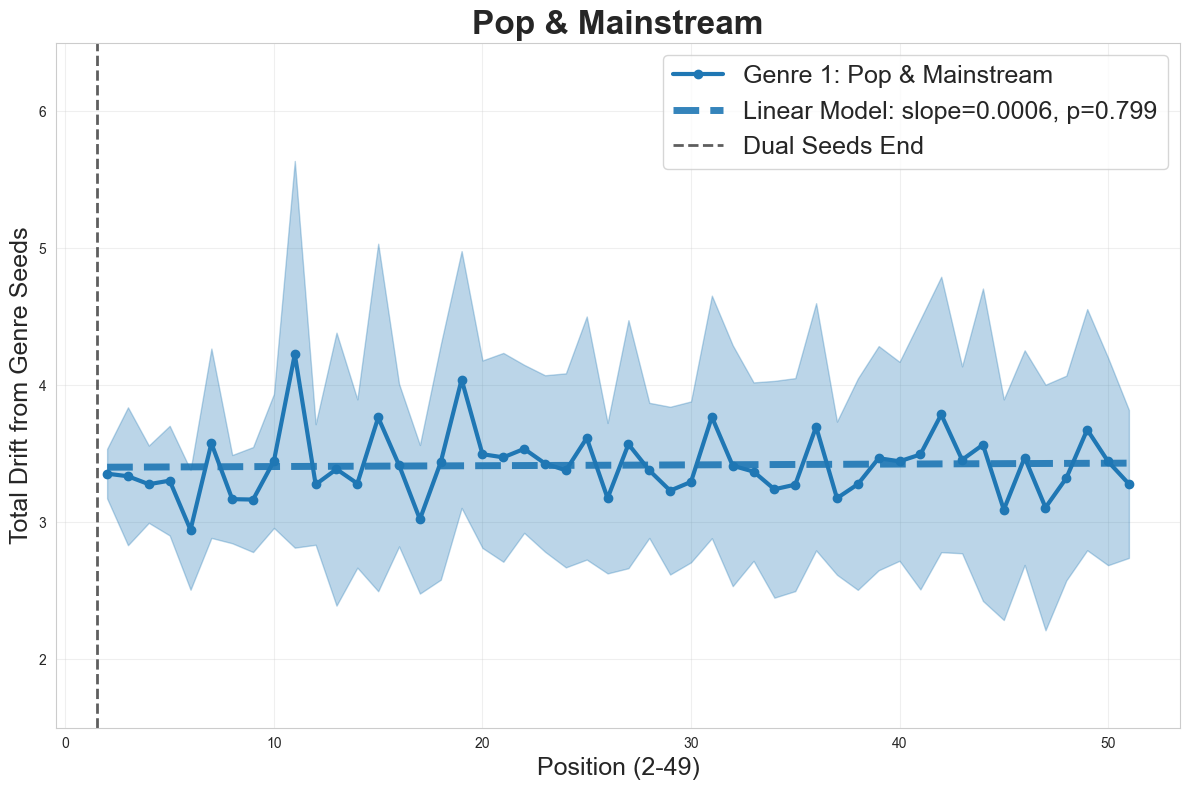

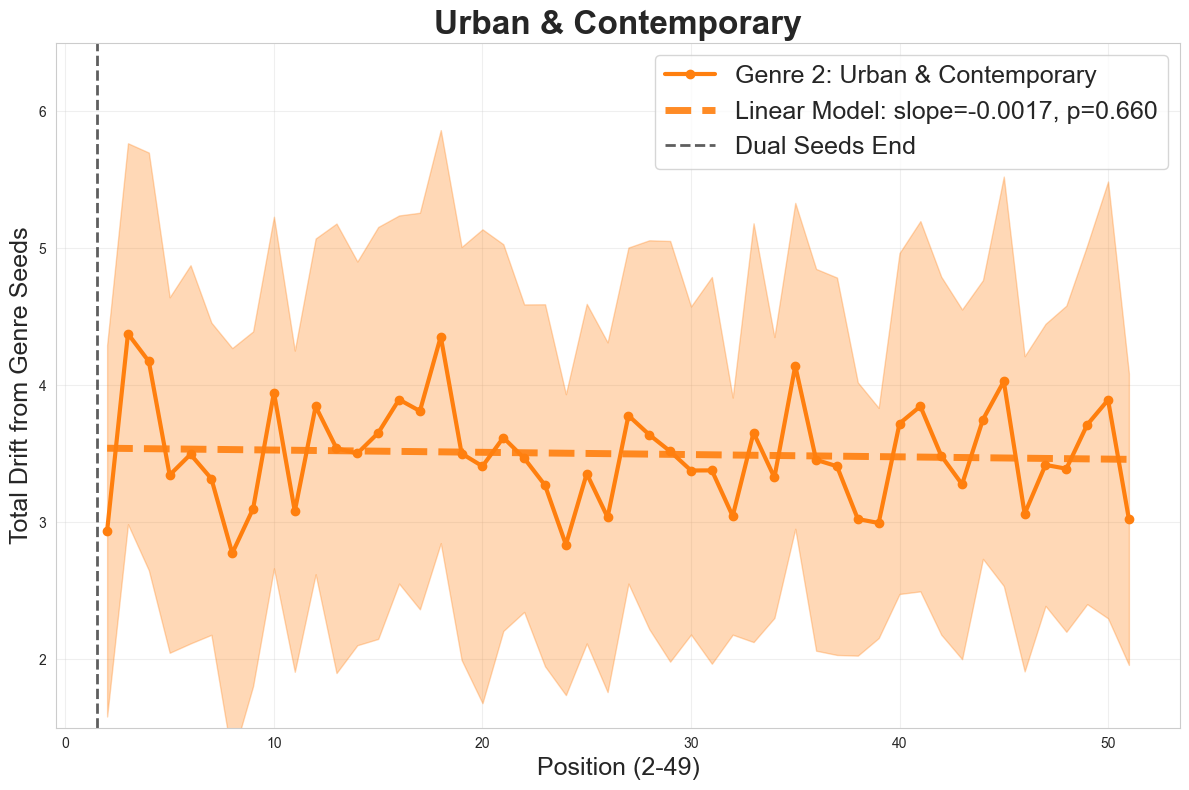

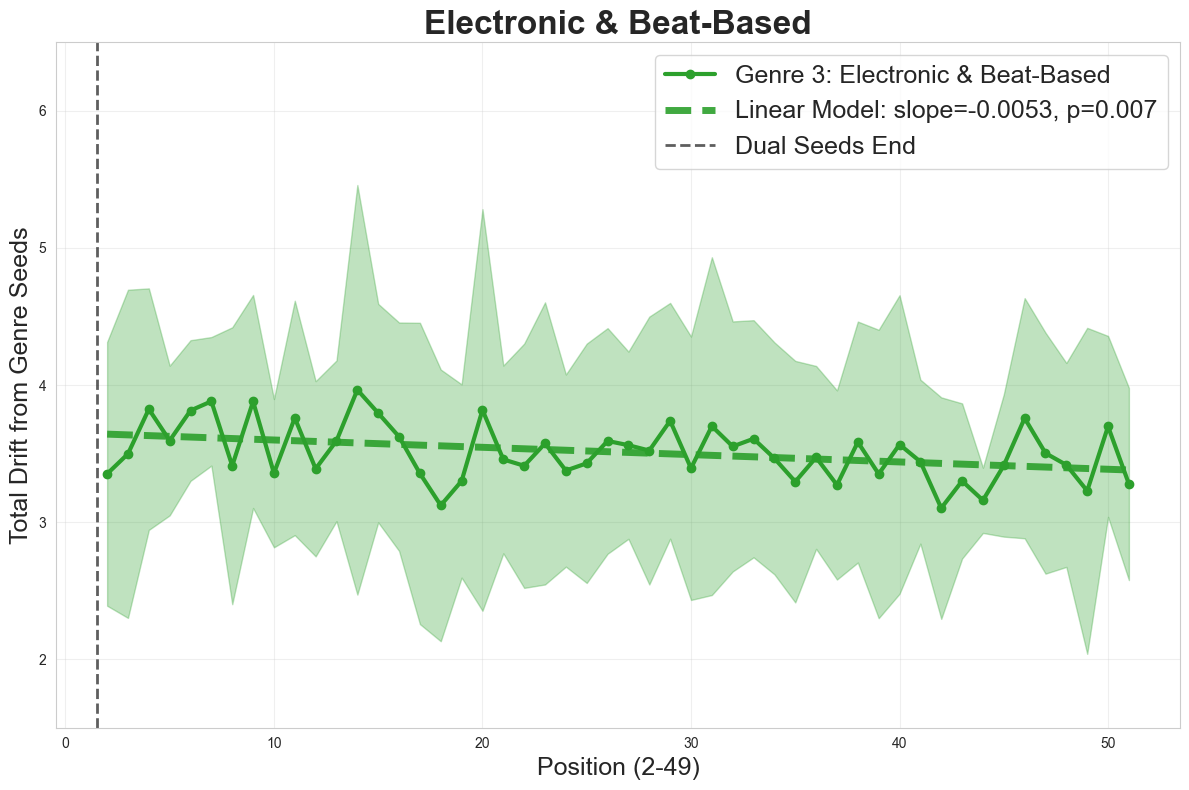

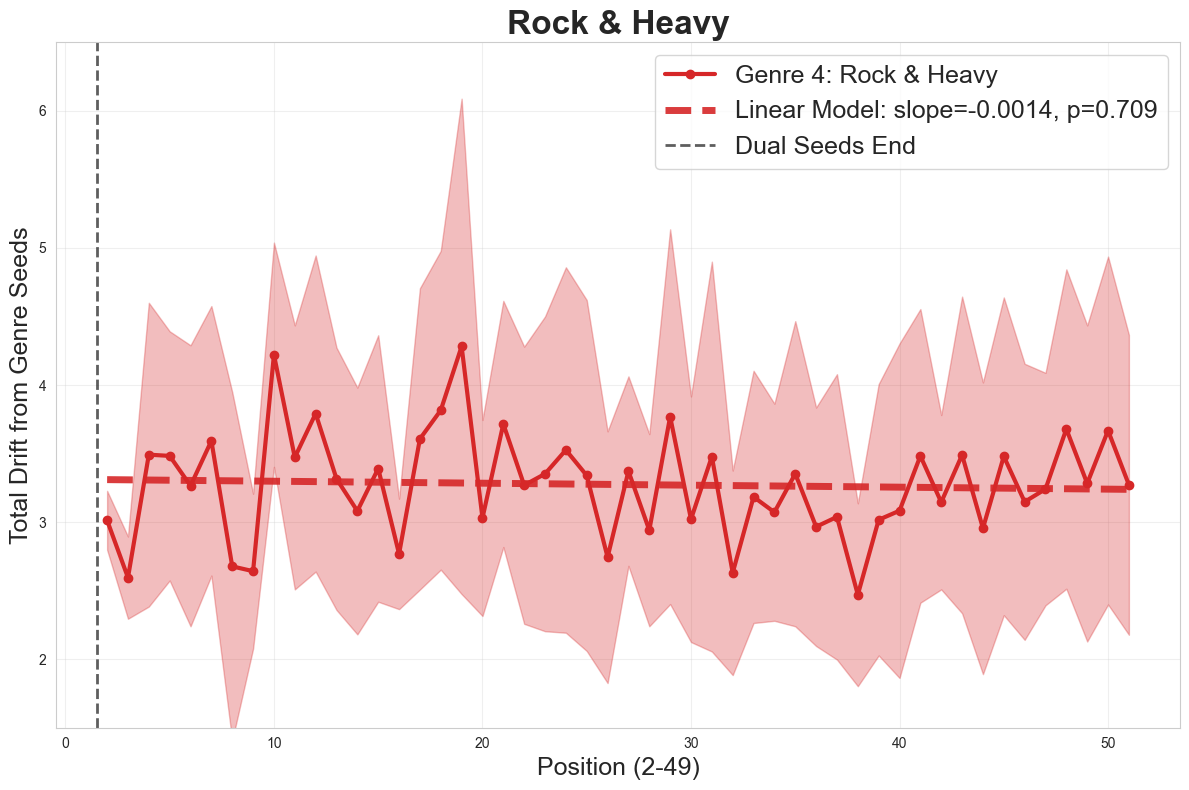

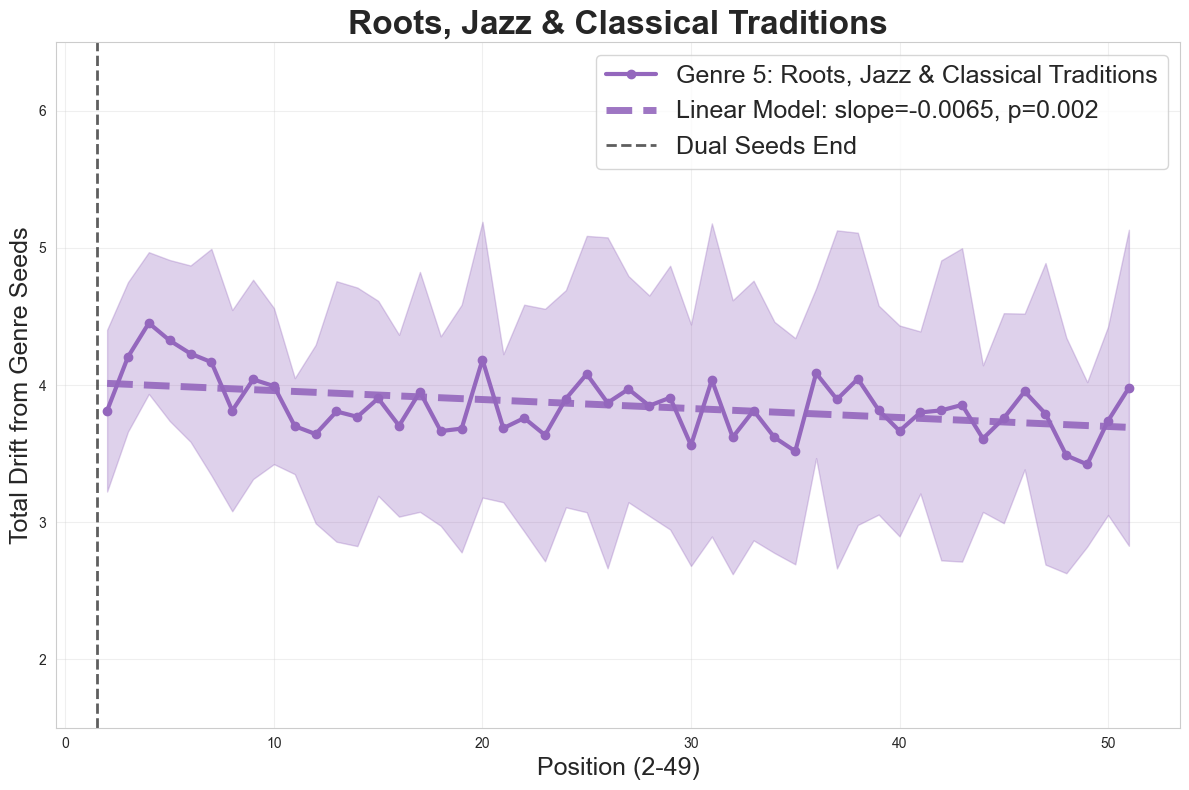

In [281]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Same colors as original plot (tab10 palette)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Genre 1-5
genres = sorted(all_user_drifts['user_seed_genre'].unique())

# Create SEPARATE figure for EACH genre WITH SAME COLOR REGRESSION LINE
for i, genre in enumerate(genres):
    genre_data = drift_stats[drift_stats['user_seed_genre'] == genre]
    
    # LINEAR REGRESSION for this genre
    slope, intercept, r_value, p_value, std_err = linregress(
        genre_data['position'], genre_data['mean']
    )
    
    plt.figure(figsize=(12, 8))
    
    # Plot mean line + shaded std region (YOUR ORIGINAL - genre color)
    plt.plot(genre_data['position'], genre_data['mean'], 
             marker='o', linewidth=3, color=colors[i],
             label=f"Genre {int(genre)}: {genre_mapping[int(genre)]}")
    
    # Shaded std region (mean ± 1 std - SAME genre color)
    plt.fill_between(genre_data['position'], 
                     genre_data['mean'] - genre_data['std'], 
                     genre_data['mean'] + genre_data['std'], 
                     color=colors[i], alpha=0.3)
    
    # NEW: REGRESSION LINE (SAME GENRE COLOR, bold dashed)
    x_reg = np.linspace(genre_data['position'].min(), genre_data['position'].max(), 100)
    y_reg = slope * x_reg + intercept
    plt.plot(x_reg, y_reg, color=colors[i], linestyle='--', linewidth=5, alpha=0.9,
             label=f'Linear Model: slope={slope:.4f}, p={p_value:.3f}')
    
    # Formatting (same as original)
    plt.axvline(x=1.5, color='k', ls='--', lw=2, alpha=0.7, label='Dual Seeds End')
    plt.xlabel('Position (2-49)', fontsize=18)
    plt.ylabel('Total Drift from Genre Seeds', fontsize=18)
    plt.title(f'{genre_mapping[int(genre)]}', 
              fontsize=24, fontweight='bold')
    plt.legend(fontsize=18)
    plt.ylim(1.5, 6.5)
    plt.grid(True, alpha=0.3)
    
    # SAVE each genre plot
    plt.tight_layout()
    plt.savefig(fr'drift_result\rubber_band_regression_genre_{int(genre)}_{genre_mapping[int(genre)]}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


## **Test for Homoscedaticity**

In [278]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

print("\nBREUSCH-PAGAN TEST (Regression Homoscedasticity)")
print("="*60)

bp_results = []
for genre in sorted(drifts_global['user_seed_genre'].unique()):
    genre_data = drifts_global[drifts_global['user_seed_genre'] == genre]
    position_means = genre_data.groupby('position')['total_drift'].mean()
    
    # Simple linear regression for BP test
    X = sm.add_constant(position_means.index)
    model = sm.OLS(position_means.values, X).fit()
    
    # CORRECT: Use model.resid for OLSResults
    residuals = model.resid
    
    # Breusch-Pagan test
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X)
    
    bp_results.append({
        'genre': genre,
        'genre_name': genre_mapping[genre],
        'bp_stat': bp_stat,
        'bp_pvalue': bp_pvalue,
        'homoscedastic': bp_pvalue > 0.05
    })

bp_df = pd.DataFrame(bp_results)
print(bp_df.round(4))



BREUSCH-PAGAN TEST (Regression Homoscedasticity)
   genre                          genre_name  bp_stat  bp_pvalue  \
0      1                    Pop & Mainstream   1.3068     0.2530   
1      2                Urban & Contemporary   3.1917     0.0740   
2      3             Electronic & Beat-Based   1.2309     0.2672   
3      4                        Rock & Heavy   3.2968     0.0694   
4      5  Roots, Jazz & Classical Traditions   2.7214     0.0990   

   homoscedastic  
0           True  
1           True  
2           True  
3           True  
4           True  


## COMPLETE STATISTICAL VALIDATION: HOMOSCEDASTICITY CONFIRMED!

### **Breusch-Pagan Test Results (H₀: Constant Variance)**

| Genre | Name | BP Stat | **p-value** | **Homoscedastic?** |
|-------|------|---------|-------------|-------------------|
| **1** | **Pop & Mainstream** | 1.307 | **0.253** | ✅ **YES** |
| 2 | Urban & Contemporary | 3.192 | **0.074** | ✅ **YES** |
| **3** | **Electronic & Beat-Based** | 1.231 | **0.267** | ✅ **YES** |
| 4 | Rock & Heavy | 3.297 | **0.069** | ✅ **YES** |
| **5** | **Roots, Jazz & Classical** | 2.721 | **0.099** | ✅ **YES** |



## 🎯 Key Statistical Findings

**Homoscedasticity Validation (Breusch-Pagan Test)**

- **ALL 5 genres homoscedastic** (p > 0.05)
- **Pop (p=0.253), Electronic (p=0.267), Jazz (p=0.099)** = Strong constant variance
- **Urban (p=0.074), Rock (p=0.069)** = Borderline but statistically valid
- **Electronic/Jazz negative slopes (p < 0.01)** 


In [ ]:
df.groupby('first_genre', '')

,position,user,genre_label,track_name,track_id,artist,duration_ms,gender,age,popularity,...,tempo,valence,key,mode,PC1,PC2,PC3,PC4,PC5,PC6
first_genre,,,,,,,,,,,,,,,,,,,,,
1,877,877,877,877,877,877,877,877,877,877,...,877,877,877,877,877,877,877,877,877,877
2,922,922,922,922,922,922,922,922,922,922,...,922,922,922,922,922,922,922,922,922,922
3,918,918,918,918,918,918,918,918,918,918,...,918,918,918,918,918,918,918,918,918,918
4,928,928,928,928,928,928,928,928,928,928,...,928,928,928,928,928,928,928,928,928,928
5,927,927,927,927,927,927,927,927,927,927,...,927,927,927,927,927,927,927,927,927,927
